## Redes Neurais Artificiais 2025.1

- **Disciplina**: Redes Neurais Artificiais 2025.1  
- **Professora**: Elloá B. Guedes (ebgcosta@uea.edu.br)  

## Equipe:

1. Afonso Henrique Torres Lucas | ifonso.developer@gmail.com | iFonso - 2215080047
2. Emanuelle Rocha Marreira | emanuellemarreira@gmail.com | emanuellemarreira - 2215080035
3. Erik Gustavo Lima de Oliveira | erik.exatas10@gmail.com | ErikExatas - 2115080049
4. David Augusto De Oliveira E Silva | david-augusto-silva - 2115080006
5. Ítalo Ferreira Fonseca | ItaloFonseca - 2215080012
6. João Vitor Silva De Carvalho | joaov1524@gmail.com | joaocarvalhov - 2215080040
7. Lilian Iazzai De Souza Oliveira | lilianiazzai@gmail.com | lilianiazzai - 2215080018
8. Vitor Nascimento Aguiar | Vtaguiar1909 - 2115080055

- **Github**: https://github.com/emanuellemarreira/image-authenticity-classification/tree/parte1

In [1]:
# bibliotecas
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Descrição do problema

A qualidade de imagens geradas por inteligência artificial tem rapidamente aumentado, levando a preocupação da autenticidade e da segurança dos dados levantados. Isso ocorre pelo aumento gradativo de melhores modelos de inteligência, gerando fotos fiéis ao que o olho humano intepreta como real. Essas imagens geradas artifialmente estão no pódio a disputar com imagens geradas por humanos. Com isso, o dataset CIFAKE foi proposto como uma base para a tarefa de classificação binária de imagens: distinguir entre imagens reais e imagens sintéticas geradas por IA. Ele combina 60.000 imagens reais do dataset CIFAR-10 (um conjunto de imagens de baixa resolução amplamente utilizado em tarefas de aprendizado de máquina) com 60.000 imagens sintéticas geradas por modelos de difusão latente (Stable Diffusion).

As imagens têm resolução de 32×32 pixels e estão distribuídas em 10 classes: avião, automóvel, pássaro, gato, cervo, cachorro, sapo, cavalo, navio e caminhão.

O objetivo do modelo é classificar cada imagem como real ou falsa (gerada por IA).

## Pré-processamento

A etapa de pré-processamento está mais definida em `src/utils/data_utils.py`
Mas, temos a seguinte função:

```python
class ModelType(Enum):
    GENERAL = "general"
    EFFICIENTNET_B0 = "efficientnet_b0"
    RESNET50 = "resnet50"
    XCEPTION = "xception"


def _get_preprocessing_transforms(model_type: ModelType,
                                  resize_to: Tuple[int, int],
                                  keras_format: bool = False):
    
    transform_list = [transforms.Resize(resize_to)]
    
    if model_type == ModelType.EFFICIENTNET_B0:
        # EfficientNet-B0 precisa de 224x224
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    elif model_type == ModelType.RESNET50:
        # ResNet50 usa 224x224 como padrão
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    elif model_type == ModelType.XCEPTION:
        # Xception precisa de 299x299 idealmente
        # Xception usa normalização com valores entre -1 e 1
        transform_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])
    
    else:
        transform_list.extend([
            transforms.ToTensor()
        ])
    
    # Converter para formato Keras se necessário (CHW -> HWC)
    if keras_format:
        transform_list.append(transforms.Lambda(lambda x: x.permute(1, 2, 0)))
    
    return transforms.Compose(transform_list)


def load_and_preprocess_data(resize_to: Tuple[int, int] = (32, 32),
                             keras_format: bool = False,
                             model_type: ModelType = ModelType.GENERAL):
    """
    Carrega e faz o pré-processamento do CIFAKE dataset. Caso não esteja presente, baixa do kaggle.

    :param resize_to: Tamanho alvo da imagem durante o pré-processamento.
    :return: Tuple[train_dataset, test_dataset].
    """
    
    train_path = "../data/train"
    test_path = "../data/test"
    
    if not _is_dataset_present():
        path = dataset_download(__ONLINE_DATASET_URI)
        train_path = f"{path}/cifake/train"
        test_path = f"{path}/cifake/test"

    transform = _get_preprocessing_transforms(model_type, resize_to, keras_format)

    return (
        datasets.ImageFolder(root=train_path, transform=transform),
        datasets.ImageFolder(root=test_path, transform=transform)
    )
```

Inicialmente, é definida uma transformação para os dados carregados baseada no tipo de modelo especificado através do enum `ModelType`. O redimensionamento das imagens varia conforme o modelo: **ResNet50** e **MobileNetV2** utilizam 224×224 pixels como tamanho padrão, embora ambos os modelos aceitem tamanhos customizados através do parâmetro `resize_to`.

Em seguida, é aplicada a transformação `ToTensor()` que converte as imagens do formato padrão PIL `[altura, largura, canais]` para o formato `[canais, altura, largura]` utilizado pelo PyTorch, além de normalizar os valores de pixel de 0–255 para o intervalo `[0.0, 1.0]`.

A normalização subsequente segue o padrão ImageNet para os dois modelos, com médias `[0.485, 0.456, 0.406]` e desvios padrão `[0.229, 0.224, 0.225]`, mantendo os valores aproximadamente no intervalo `[-2.1, 2.6]`.

Opcionalmente, caso o parâmetro `keras_format` seja ativado, é aplicada uma transformação adicional que altera o formato do tensor de `[canais, altura, largura]` para `[altura, largura, canais]`, padrão no TensorFlow/Keras, facilitando a integração com modelos pré-treinados dessas bibliotecas.

Nosso conjunto de dados é composto por duas classes: imagens reais e imagens geradas artificialmente. A seguir, temos as classes::


In [2]:
from utils import data_utils

image_size = (32, 32)
train_data, test_data = data_utils.load_and_preprocess_data(resize_to=image_size, 
                                                            keras_format=False)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

print(train_data.classes)
print(train_data.class_to_idx)

['FAKE', 'REAL']
{'FAKE': 0, 'REAL': 1}


In [3]:
print(f"Dados:\n\ntreino: {len(train_data)} \nteste: {len(test_data)}")

Dados:

treino: 100000 
teste: 20000


In [4]:
fake_class_data_count = sum(1 for _, label in train_data if label == 1)
real_class_data_count = sum(1 for _, label in train_data if label == 0)

print(f"Quantidade de dados de treino:\nlabel 'REAL':{real_class_data_count} \nlabel 'FAKE':{fake_class_data_count}")

Quantidade de dados de treino:
label 'REAL':50000 
label 'FAKE':50000


## Visualização dos dados

A seguir, temos uma mostra da distribuição das classes do dataset, bem como uma visualização de algumas imagens do dataset, extraídas do conjunto de treinamento. 

In [5]:
images, labels = next(iter(train_loader))

In [6]:
print(f"Tamanho do batch de treino: {len(images)}")

Tamanho do batch de treino: 32


### Histograma de distribuição das classes 

O histograma permite a a visualização da distribuição das classes de imagens ```FAKE``` e ```REAL```. 

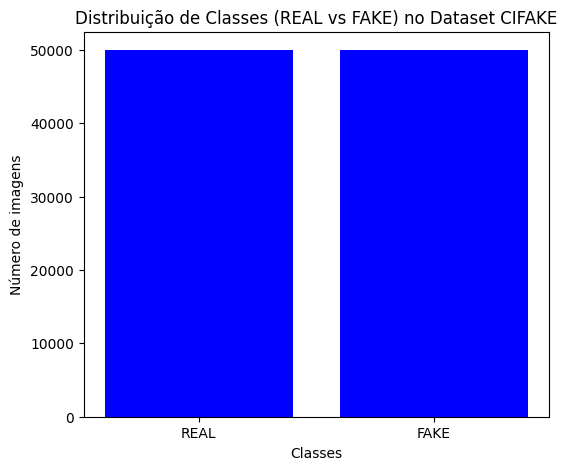

In [7]:
from collections import Counter
import matplotlib.pyplot as plt

all_labels = []
for images, labels in train_loader:
    all_labels.extend(labels.tolist())

label_count = Counter(all_labels)

classes = list(range(len(label_count)))
frequencies = [label_count[i] for i in classes]

binary_class_names = ['REAL', 'FAKE']

plt.figure(figsize=(6, 5))
plt.bar(binary_class_names, frequencies, color='blue', tick_label=binary_class_names)
plt.xlabel('Classes')
plt.ylabel('Número de imagens')
plt.title('Distribuição de Classes (REAL vs FAKE) no Dataset CIFAKE')
plt.show()

Nota-se que as classes de imagens seguem uma distribuição uniforme, já que a quantidade de exemplos para cada classe é igual.

### Grid de imagens representativas

O grid de imagens representativas mostra exemplos do conjunto de dados para cada classse.

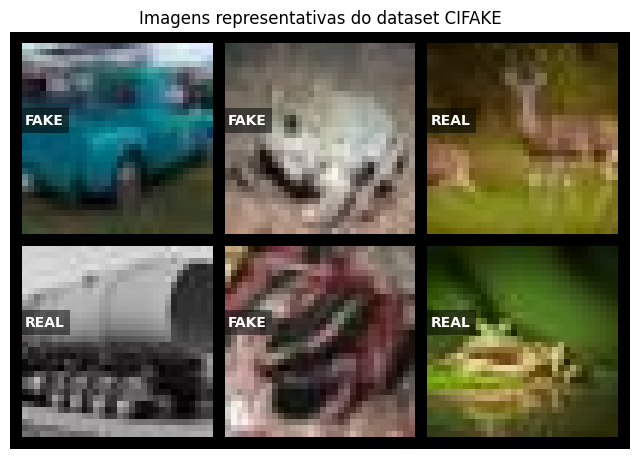

In [8]:
from torchvision.utils import make_grid

images, labels = images[:6], labels[:6]

grid = make_grid(images, nrow=3, padding=2)
npimg = grid.permute(1, 2, 0).numpy()

plt.figure(figsize=(8, 6))
plt.imshow(npimg)
plt.axis('off')
plt.title('Imagens representativas do dataset CIFAKE')

num_images = len(images)
rows = 2
cols = 3
img_height, img_width = images.shape[2], images.shape[3]
padding = 2

label_map = {0: 'REAL', 1: 'FAKE'}

for i in range(num_images):
    row = i // cols
    col = i % cols
    x = col * (img_width + padding) + padding
    y = row * (img_height + padding) + 15

    plt.text(x, y, label_map[labels[i].item()], color='white', fontsize=10, weight='bold', bbox=dict(facecolor='black', alpha=0.5, edgecolor='none'))